## Setup model

### Initialize electrode locations

In [1]:
import numpy as np
import pandas as pd
import h5py

# elec_pos = np.column_stack((np.zeros(96),np.linspace(-1900,1900,96),np.zeros(96)))

# # save electrode position to file
# elec_file = 'sim_details/linear_electrode.csv'
# df = {'channel':np.arange(elec_pos.shape[0])}
# df.update({x+'_pos':elec_pos[:,i] for i,x in enumerate(list('xyz'))})
# df = pd.DataFrame(df)
# df.to_csv(elec_file,sep=' ',index=False)

with h5py.File('Electrode2D.h5', "r") as f:
    elec_file = 'sim_details/linear_electrode.csv'  # It isn't linear but in order to not change configs I kept the name
    elec_pos = np.hstack((f['coord'][:], np.zeros((384,1))))
    df = {'channel':np.arange(elec_pos.shape[0])}
    df.update({x+'_pos':elec_pos[:,i] for i,x in enumerate(list('xyz'))})
    df = pd.DataFrame(df)
    df.to_csv(elec_file,sep=' ',index=False)

### Select model

In [2]:
# model_name = 'neuronal_model_496930324'
# syn_weight = 0.01
# model_name = 'neuronal_model_497229089'
# syn_weight = 0.03
model_name = 'neuronal_model_491766131'
syn_weight = 0.02

dynamics_params = model_name + '.json'
morphology = model_name+'_rotate.swc'

### Copy model files

In [3]:
import os, shutil

# shutil.copy(model_name + '/fit_parameters.json','sim_details/components/biophysical_neuron_models/' + dynamics_params)

### Select translation distance and rotation angles, and convert to euler angles in bmtk

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation as R

x = 0
y = 350
z = 80
theta = 0.
h = 0.7071
phi = 0.

Rot = R.from_euler('yxy',[theta,np.arccos(h),phi])
rot_zyx = Rot.as_euler('zyx')

In [5]:
# # block basal dendrite
# model_name += '_nobasal'
# dynamics_params = model_name + '.json'

### Build bmtk network

In [6]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('Cell')
net.add_nodes(cell_name = 'Cell',
              positions = np.array([[x,y,z]]),
              rotation_angle_xaxis = rot_zyx[2], # rotation cell
              rotation_angle_yaxis = rot_zyx[1],
              rotation_angle_zaxis = rot_zyx[0],
#               orientation=quaternion, # this option seems not implemented in bmtk
              potental = 'exc',
              model_type = 'biophysical',
              model_template = 'ctdb:Biophys1.hoc',
              model_processing = 'aibs_allactive',
              dynamics_params = dynamics_params, #from allen database
              morphology = morphology) # rotated swc file

In [7]:
net.build()
net.save_nodes(output_dir='network')

In [8]:
source = NetworkBuilder('Source')
source.add_nodes(N=1,pop_name='Source',potential='exc',model_type='virtual')

In [9]:
source.add_edges(source={'pop_name':'Source'},target=net.nodes(),
                   connection_rule=1,
                   syn_weight=syn_weight,
                   delay=0.0,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0,1000.0],
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='exp2syn')

In [10]:
source.build()
source.save_nodes(output_dir='network')
source.save_edges(output_dir='network')

#### Synaptic input spike

In [11]:
import pandas as pd

spike = pd.DataFrame(data={'node_ids':[0],'timestamps':[10.0],'population':['Source']})
spike.to_csv('sim_details/synaptic_input.csv',sep=' ',index=False)

### Build

In [12]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='sim_details',
                 network_dir='network',
                 tstop=30.0, dt=0.025,
                 v_init=-91.63188171386719, # use e_pas in dynamics_params file
                 report_vars=['v','ecp'],
                 spikes_inputs=[('Source','sim_details/synaptic_input.csv')],
                 config_file = 'config.json',
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

ERROR:bmtk.utils.sim_setup:  Was unable to compile mechanism in D:\reserch_temp\detailed-single-cell\sim_details\components\mechanisms


Remember to add 'ecp_report' module to the simulation_config.json file. See example in the config file in the root directory.

In [13]:
import os, shutil
shutil.copy('simulation_config.json','sim_details/simulation_config.json')

'sim_details/simulation_config.json'

### Run bmtk

In [14]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('sim_details/config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)

2022-07-15 16:51:54,709 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-07-15 16:51:54,843 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-07-15 16:51:55,161 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-07-15 16:51:55,167 [INFO] Building virtual cell stimulations for Source_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for Source_spikes


#### Record axial current

In [15]:
from utils.currents.somaaxialcurrent import Soma_Axial_Current

axial_current = Soma_Axial_Current(sim.net.get_cell_gid(0).get_section(0),record_t=True)
sim.run()

2022-07-15 16:51:55,307 [INFO] Running simulation for 30.000 ms with the time step 0.025 ms


INFO:NEURONIOUtils:Running simulation for 30.000 ms with the time step 0.025 ms


2022-07-15 16:51:55,309 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-07-15 16:51:55,313 [INFO] Block save every 1200 steps


INFO:NEURONIOUtils:Block save every 1200 steps


2022-07-15 16:51:58,351 [INFO]     step:1200 t_sim:30.00 ms


INFO:NEURONIOUtils:    step:1200 t_sim:30.00 ms


2022-07-15 16:51:58,419 [INFO] Simulation completed in 3.111 seconds 


INFO:NEURONIOUtils:Simulation completed in 3.111 seconds 


#### Check morphology
Function to plot morphology

In [16]:
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib notebook

def plot_morphology(network,gid=0,rotated=True,figsize=(8,6),ax=None):
    cell = network.get_cell_gid(gid)
    morph = cell.morphology
    if rotated:
        coords = cell.get_seg_coords()
    else:
        coords = morph.seg_coords
    stype = morph.seg_prop['type'].astype(int)-1
    st = list(morph.sec_type_swc.keys())[::2]
    ilab = [list(stype).index(i) for i in range(len(st))]
    clr = ['g','r','b','c']
    if ax is None:
        print(cell.morphology_file)
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
    else:
        fig = ax.figure
        fig.set_size_inches(figsize)
    for i in range(stype.size):
        label = st[ilab.index(i)] if i in ilab else None
        if stype[i]==0:
            ax.scatter(*coords['p05'][:,i].tolist(),c=clr[0],s=30,label=label)
        else:
            ax.plot3D(*[[coords['p0'][j,i],coords['p1'][j,i]] for j in range(3)],
                      color=clr[stype[i]],label=label)
    ax.legend(loc=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

D:\reserch_temp\detailed-single-cell\sim_details\components\morphologies\neuronal_model_491766131_rotate.swc


<IPython.core.display.Javascript object>


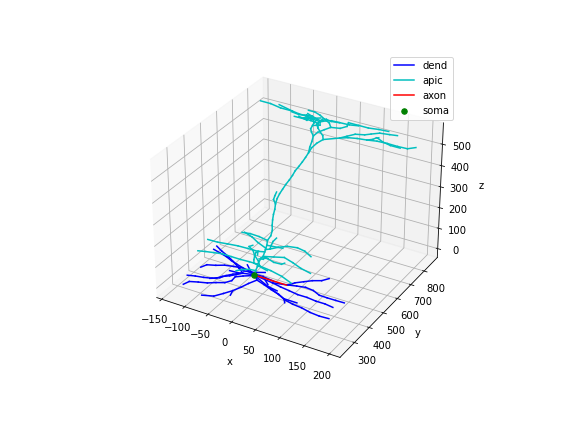

In [26]:
%matplotlib notebook

_ = plot_morphology(net,0,rotated=True)

Check diameters

### Check axial currents

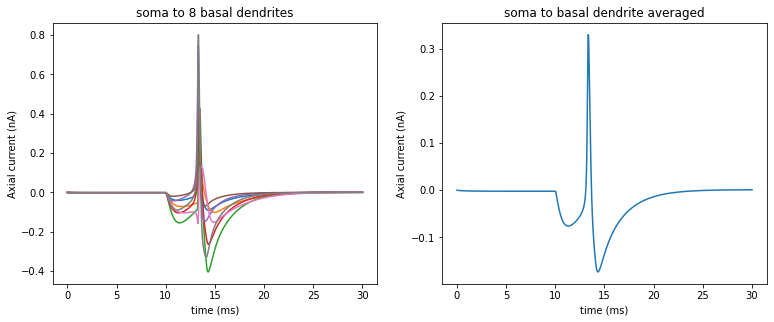

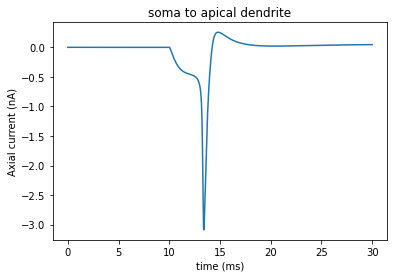

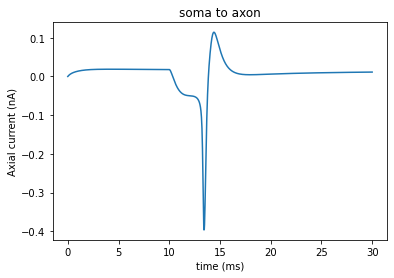

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

t = axial_current.t()
ac = axial_current.get_current()

ac_dend = ac['dend'].T
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
plt.plot(t,ac_dend)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to {} basal dendrites'.format(ac_dend.shape[1]))
plt.subplot(122)
plt.plot(t,np.mean(ac_dend,axis=1))
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to basal dendrite averaged')
plt.show()

ac_apic = ac['apic'].T
plt.figure()
plt.plot(t,ac_apic)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to apical dendrite')
plt.show()

ac_axon = ac['axon'].T
plt.figure()
plt.plot(t,ac_axon)
plt.xlabel('time (ms)')
plt.ylabel('Axial current (nA)')
plt.title('soma to axon')
plt.show()

### Check Results

In [19]:
import h5py
import numpy as np
import pandas as pd
import os

outpath = 'sim_details/output/'

#### Check membrane voltage

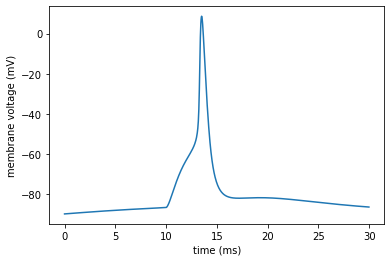

In [20]:
filename = 'v_report.h5'
v_file = outpath + filename
v_f = h5py.File(v_file,'r')

V = v_f['report/Cell/data'][()]
t = np.arange(*v_f['report/Cell/mapping/time']) # array of time

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(t,V)
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.show()

#### Check LFP

In [21]:
filename = 'ecp.h5'
ecp_file = outpath + filename
ecp_f = h5py.File(ecp_file,'r')
lfp = ecp_f['ecp/data'][()]
t = np.arange(*v_f['report/Cell/mapping/time']) # array of time
fs = 1000/v_f['report/Cell/mapping/time'][2]

In [22]:
from scipy import signal

filt_b,filt_a = signal.butter(2,100,'hp',fs=fs)
lfp_filt = signal.lfilter(filt_b,filt_a,lfp,axis=0)

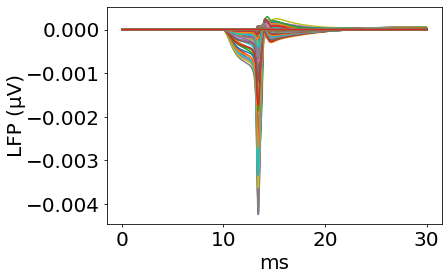

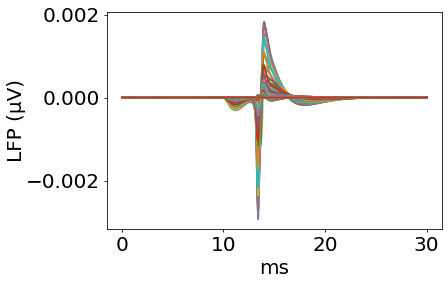

Text(0.5, 1.0, 'Filtered LFP')

In [23]:
from utils.plotting.plot_results import *

idx = (t>=0) & (t<=30)

fig,ax = plot_lfp_traces(t[idx],lfp[idx,:],
                         fontsize=20,labelpad=0,tick_length=3,nbins=5)
ax.set_title('LFP from all electrodes')

fig,ax = plot_lfp_traces(t[idx],lfp_filt[idx,:],
                         fontsize=20,labelpad=0,tick_length=3,nbins=5)
ax.set_title('Filtered LFP')

Using column at x = -8 um


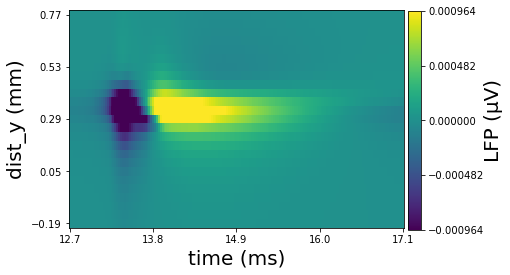

In [24]:
window = 4.4
tstart = 12.7
# tstart = 10.5 # no basal
idx = (t>=tstart) & (t<=tstart+window)

vlim = 'auto'
# vlim = [-0.0005,0.0005]
ylim = [-200,800]

x_dist = np.unique(elec_pos[:,0])
ix = 1
e_idx = (elec_pos[:,0]==x_dist[ix]) & (elec_pos[:,1]>=ylim[0]) & (elec_pos[:,1]<=ylim[1])
print('Using column at x = %g um' % (x_dist[ix]))

fig,ax = plot_lfp_heatmap(t[idx],elec_pos[e_idx, 1],
                          lfp_filt[idx][:, e_idx],vlim=vlim,
                          fontsize=20,labelpad=0,ticksize=10,nbins=5)

Save to h5 file

In [25]:
lfp_file_name = 'lfp_result/' + model_name + '_h' + str(h) + '.h5'
hf = h5py.File(lfp_file_name, 'w')
hf.attrs['dt'] = sim.dt
hf.create_dataset('data',data=lfp_filt)
for dend,AC in ac.items():
    hf.create_dataset('axial_current/'+dend,data=AC)
hf.close()